# Importing Libraries

In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
%tensorflow_version 1.15.0
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
Found GPU at: /device:GPU:0


In [3]:
#!pip install --quiet gast==0.2.2
!pip install --quiet keras==2.1.6
!pip install --quiet flowpm==0.1

     |████████████████████████████████| 339 kB 8.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.15.2 which is incompatible.


In [4]:
import tensorflow as tf
from tensorflow.contrib.opt import ScipyOptimizerInterface
print(tf.version.VERSION)

import scipy
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
from scipy import ndimage

import numpy as np

import flowpm
from flowpm.kernels import fftk
from flowpm import linear_field, lpt_init, nbody, cic_paint
import flowpm.tfpm as tfpm
import flowpm.utils as pmutils

%pylab inline

1.15.2
Populating the interactive namespace from numpy and matplotlib


# Global simulation parameters

In [5]:
bs = 64 #simulation box size in Mpc/h
nc = 64 #particle number sidelength (i.e. nc**3 is number of particles in sim)

k_min = 0.1 #minimum k-value for binned powerspectra
dk = 0.25 #differential in each kbin

# Power spectrum model
def true_test_powerspectrum(k, A, n, m):
    return A*(k + m*n)**n


### Planck 2015 approximate power spectra

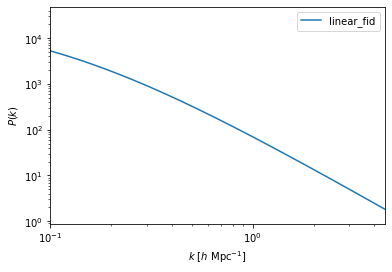

In [9]:
klin = np.arange(0.001, 5, 0.01)
plin = np.zeros(len(klin))
i=0
for k in klin:
    plin[i] = true_test_powerspectrum(k, 90, -2.55, -0.04)
    i += 1

# estimate fiducial cosmology function
ipklin = iuspline(klin, plin)

# change paths to plot Planck 2015 ps
#klin_planck = np.loadtxt('./Planck15_a1p00.txt').T[0]
#plin_planck = np.loadtxt('./Planck15_a1p00.txt').T[1]

plt.loglog(klin, plin, label="linear_fid")
#plt.loglog(klin_planck, plin_planck, label="Planck_2015_fid")
plt.xlim([0.1, 4.5])
plt.xlabel("$k$ [$h$ Mpc$^{-1}]$")
plt.ylabel("$P(k)$")
legend()

#np.random.seed(0)

# Helper Functions
### i) Global power spectra helper functions

In [10]:
def _initialize_pk(shape,boxsize,kmin,dk):
    """
       Helper function to initialize various (fixed) values for powerspectra... not differentiable!
    """
    I = np.eye(len(shape), dtype='int') * -2 + 1

    W = np.empty(shape, dtype='f4')
    W[...] = 2.0
    W[..., 0] = 1.0
    W[..., -1] = 1.0
    kedges = np.arange(kmin, np.pi * 3 / 2 + dk/2, dk)
    #kedges = np.logspace(log10(kmin), log10(np.pi * 3 / 2 + dk/2), 9)

    k = [np.fft.fftfreq(N, 1. / (N * 2 * np.pi / L))[:pkshape].reshape(kshape) for N, L, kshape, pkshape in zip(shape.as_list(), boxsize, I, shape.as_list())]
    kmag = sum(ki ** 2 for ki in k) ** 0.5

    xsum = np.zeros(len(kedges) + 1)
    Nsum = np.zeros(len(kedges) + 1)

    dig = np.digitize(kmag.flat, kedges)

    #print(dig.size,xsum.size,len((W * kmag).flat))
    xsum.flat += np.bincount(dig, weights=(W * kmag).flat, minlength=xsum.size)
    Nsum.flat += np.bincount(dig, weights=W.flat, minlength=xsum.size)
    dig = tf.convert_to_tensor(dig,dtype=tf.int32)
    Nsum = tf.convert_to_tensor(Nsum,dtype=tf.complex64)
    xsum = tf.convert_to_tensor(np.array(xsum))
    W = tf.convert_to_tensor(np.array(W))
    k = np.array(k)
    kedges = tf.convert_to_tensor(np.array(kedges))
    return dig, Nsum, xsum, W, k, kedges

In [11]:
def pk(field, kmin=5, dk=0.8, shape = False, boxsize= False):   
    """
    Calculate the powerspectra given real space field
    
    Args:
        
        field: real valued field 
        kmin: minimum k-value for binned powerspectra
        dk: differential in each kbin
        shape: shape of field to calculate field (can be strangely shaped?)
        boxsize: length of each boxlength (can be strangly shaped?)
    
    Returns:
        
        kbins: the central value of the bins for plotting
        power: real valued array of power in each bin
        
    """
    #initialze values related to powerspectra
    dig, Nsum, xsum, W, k, kedges = _initialize_pk(shape,boxsize,kmin,dk)
    
    #convert field to complex for fft
    field_complex = tf.dtypes.cast(field,dtype=tf.complex64)

    #fast fourier transform
    fft_image = tf.signal.fft3d(field_complex)
    
    #absolute value of fast fourier transform
    pk = tf.math.real(fft_image*tf.math.conj(fft_image))
    #calculating powerspectra
    Psum = tf.zeros(tf.size(kedges) + 1, dtype=tf.complex64)
    real = tf.reshape(tf.math.real(pk),[-1,])
    imag = tf.reshape(tf.math.imag(pk),[-1,])
    
    Psum  += tf.dtypes.cast(tf.math.bincount(dig, weights=(tf.reshape(W,[-1])  * imag), minlength=tf.size(xsum)),dtype=tf.complex64)*1j
    Psum  += tf.dtypes.cast(tf.math.bincount(dig, weights=(tf.reshape(W,[-1]) * real), minlength=tf.size(xsum)),dtype=tf.complex64)
    #print(W.flatten()  * imag,Psum)

    power = (Psum / Nsum)[1:-1] * boxsize.prod() 
    
    #normalization for powerspectra
    norm = tf.dtypes.cast(tf.reduce_prod(shape),dtype=tf.float32)**2
    
    #find central values of each bin
    kbins = kedges[:-1]+ (kedges[1:] - kedges[:-1])/2
    
    return kbins,tf.dtypes.cast(power,dtype=tf.float32)/norm

In [12]:
def pk_func(inputs):
    nc = inputs.shape[1] #assume equal dimensions right now
    ic = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Starting Point
    pkr = pk(tf.squeeze(ic,0),shape = ic.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin= k_min,dk=dk)#dk=0.4, kmin = 0.001
    with tf.Session() as sess:
        pk_out = sess.run((pkr),{ic: inputs})
    return pk_out

In [13]:
def fourier_transform(data, divisor, axis=1, sampling=1):
    fourier = np.fft.fft(data, axis=axis)
    n = (1/sampling)*divisor
    print(data.shape[axis])
    freq = np.fft.fftfreq(data.shape[axis], n)
    fourier = np.fft.fftshift(fourier, axes=axis)
    freq = np.fft.fftshift(freq)
    return fourier, freq


def power_spectrum_1d(data, divisor, axis=1, sampling=1):
    fourier, freq = fourier_transform(data, divisor, axis=axis, sampling=1)
    power = np.conjugate(fourier)*fourier
    return power, freq

### ii) Defining optimization-related helper functions 

In [14]:
#variable noise... in this case masking the edges and including variable noise over image
a = numpy.arange(64)
numpy.random.shuffle(a)
noise_prop = np.ones((nc,nc,nc))*0.01
inv_sigma = (1/noise_prop)
def likelihood_fn(inputs, b, predictions, inv_sigma = inv_sigma):
    """ Evaluates the data chi-squared function through Fast PM
    """
    _,final_field = pm(predictions[..., 0],b)

    clipped1 = final_field
    clipped2 = inputs[...,0]
    likelihood = tf.reduce_sum((clipped1-clipped2)**2*inv_sigma**2, 
                              axis=[1, 2, 3])
    return likelihood, final_field

def likelihood_fn_lya(inputs, data, inverse_covar):
    #Evaluates the data chi-squared function through Fast PM
    #Clipping very high values which end up dominating the likelihood

    #weighted by number count in bin for poisson errors
    residual = tf.subtract(inputs, data)
    values = tf.multiply(residual, tf.transpose(tf.sparse.sparse_dense_matmul(inverse_covar, residual, adjoint_b=True)))
    return values

def smoothing(field,Rsm,kmesh,nc):
    """ smoothing field in fourier space
    """
    Rsmsq = tf.multiply(Rsm, Rsm)
    smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))

    datak = tfpm.r2c3d(field, norm=nc**3)
    datak = tf.multiply(datak, tf.cast(smwts, tf.complex64))
    dataf = tfpm.c2r3d(datak, norm=nc**3)
    return dataf

In [15]:
def pm(lin,b):
    ''' Evolution operator, NOTE: this is using all the tensorflow tensors, need to use a tf.Session() to evaluate them.
    '''
    state = flowpm.lpt_init(lin, a0=0.1)
    final_state = flowpm.nbody(state, stages, nc)
    final_field = flowpm.cic_paint(tf.zeros_like(lin), final_state[0])
    return  final_field, tf.math.exp(-1*(0.20+b[0])*final_field**(b[1]+1.8))#(0.90+0.1*b[0])*final_field + (0.20+0.1*b[1])*final_field**2.0#tf.math.exp(-(0.22+b[0]*0.0001)*final_field**(1.8+b[1]*0.0001))

In [16]:
def gen_noise(nzpix, n_skewers, snr_min, snr_max, alpha):
    #generates noise according to specified distribution
    snr = numpy.minimum(snr_min/numpy.random.power(alpha-1,size=n_skewers),snr_max)
    skewers_noise = (1.0/snr[:,numpy.newaxis])*numpy.ones(nzpix)
    return snr, skewers_noise

def likelihood_fn_lya(inputs, data, inverse_covar):
    #Evaluates the data chi-squared function through Fast PM
    #Clipping very high values which end up dominating the likelihood

    #weighted by number count in bin for poisson errors
    residual = tf.subtract(inputs, data)
    values = tf.multiply(residual, tf.transpose(tf.sparse.sparse_dense_matmul(inverse_covar, residual, adjoint_b=True)))
    return values

def reduce_sum_det(x):
    #deterministic reduce sum
    v = tf.reshape(x, [1, -1])
    return tf.reshape(tf.matmul(v, tf.ones_like(v), transpose_b=True), [])

In [17]:
class TARDIS:
    def __init__(self, isLyaReconstruction = [False, ], prior_v = [0.0,0.0]):
        self.prior_v = prior_v
        self.isLyaReconstruction = isLyaReconstruction
        self.__init__model()
    def __init__model(self):
        self.xx = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Starting Point
        if (self.isLyaReconstruction[0] == False):
            self.yy = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Data
        else:
            self.skewers_fin = self.isLyaReconstruction[1]
            self.yy = tf.placeholder(tf.float32, [self.skewers_fin.shape[0]]) #lya flux

        self.bias = tf.Variable([0.0,0.0], name="variables", trainable=True) #Bias

        self.linearkk = tf.get_variable('linmesh', shape=(1, nc, nc, nc),
                    initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
        self.initlin_op = self.linearkk.assign(self.xx, name='initlin_op')

        linear_wc = tfpm.r2c3d(self.linearkk, norm=nc**3, name=None)
        linear_k = tf.multiply(linear_wc, (pkmesh/bs**3)**0.5)
        self.linear = tfpm.c2r3d(linear_k , norm=nc**3, name=None) #*1024*np.sqrt(2) 

        # Compute the likelihood fn
        if (self.isLyaReconstruction[0] == False):
            self.likelihood, self.final_field = likelihood_fn(tf.expand_dims(self.yy, -1), self.bias, tf.expand_dims(self.linear,-1)) 
        else:
            self.inverse_covar = self.isLyaReconstruction[2]
            self.final_field, self. evolved_field_FGPA = pm(self.linear, self.bias)
            # No RSD stuff
            #evolved_field_FGPA = K.exp(-1.0*self.RSD_tau)#fgpa(self.evolved_field,bias_lya)
            #evolved_field_FGPA = np.exp(-b1*sim2**b2)

            # No smoothing for now...
            #evolved_field_FGPA_sm = smoothing(evolved_field_FGPA, Rsm, kmesh, nc)
        
            self.flux_val = flowpm.cic_readout(self.evolved_field_FGPA, np.array(self.skewers_fin,dtype=np.float32).reshape(1,-1,3))
            self.likelihood_lya = likelihood_fn_lya(self.flux_val, self.yy, self.inverse_covar)
            self.likelihood = reduce_sum_det(self.likelihood_lya)
            
        # Compute the prior on field
        prior_1 = tf.cast(tf.square(tf.abs(linear_wc)), tf.float32)#tf.reduce_sum(tf.multiply(priormesh, 1/pkmesh**2))

        # Compute the prior on the parameters
        prior_values = tf.constant(self.prior_v)
        prior_2 = tf.reduce_sum((prior_values-self.bias)**2.0)/(0.01**2) #rough gaussian prior...

        prior_total = tf.reduce_sum(prior_1)+prior_2

        self.logposterior = tf.reduce_mean(self.likelihood) +  tf.reduce_mean(prior_total)

In [18]:
def optimize(T, variable, data, maxiter, starting_point = np.random.randn(1,nc,nc,nc), gtol=1e-12, sigma=1.0, isLyaReconstruction = False):
    opt = ScipyOptimizerInterface(T.logposterior, var_list=variable, method='L-BFGS-B',
                                                    options={'maxiter': maxiter, 'gtol':gtol})
    sess.run(tf.global_variables_initializer())

    batchsize = 1
    # Initialize gradient descent at random point
    sess.run(T.initlin_op, {T.xx: starting_point});
    st = time.time()
    #opt.minimize(sess, {T.yy:data[0:1]})
    if (isLyaReconstruction == False): opt.minimize(sess, {T.yy:data[0:1]})
    else: opt.minimize(sess, {T.yy:data})
    print("Total Time:", time.time()-st)

# Ly-$\alpha$ 1-d power spectra 

In [ ]:
# Function that takes in: 
#   1) Input parameters for the linear power spectra model: A_s, n_s, m_s
#
#   2) Various skewer properties, including the number of Ly𝛼 skewers, n_skewers, 
#      the snr_min and snr_max range for the skewers, and alpha. 
#
# Returns the 1-d powerspectrum associated with the mock field and skewers evolved from the initial linear ps/field.
def condensed_1d_ps(A_s, n_s, m_s, n_skewers = 4000, snr_min = 2, snr_max = 10, alpha = 2.8):
  ########################################################
  # Making Initial Density Field
  ########################################################
  klin = np.arange(0.001, 5, 0.01)
  plin = np.zeros(len(klin))
  i=0
  for k in klin:
      plin[i] = true_test_powerspectrum(k, 90, -2.55, -0.04)
      i += 1

  # fiducial cosmology function
  ipklin = iuspline(klin, plin)

  # Set initial conditions
  initial_conditions = flowpm.linear_field(nc, bs, ipklin, batch_size=1)
  with tf.Session() as sess: linear_true = sess.run((initial_conditions))

  stages = np.linspace(0.1, 0.3, 10, endpoint=True) ## 0.3 when using lyman alpha forest
  ic = tf.placeholder(tf.float32, [1, nc, nc,nc]) #Starting Point

  # Sample particles
  state = flowpm.lpt_init(ic, a0=0.1)   

  # Evolve particles down to z=0
  final_state = flowpm.nbody(state, stages, nc)         

  # Retrieve final density field
  final_field = flowpm.cic_paint(tf.zeros_like(ic), final_state[0])

  # Calculate power spectra for intial density field
  pkr_ic = pk(tf.squeeze(ic,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=k_min,dk=dk)

  # Calculate power spectra for final density field
  pkr = pk(tf.squeeze(final_field,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=k_min,dk=dk)
          
  with tf.Session() as sess:
      sim, pkr_ic0, pkr_out = sess.run((final_field,pkr_ic,pkr),{ic: linear_true})

  # True Bias Values
  b1=.22
  b2=1.8

  noise_real = np.random.randn(nc,nc,nc)*noise_prop
  sims2 = sim #ndimage.gaussian_filter(sim,0.2,mode="wrap")
  gal= np.exp(-b1*sims2**b2) #apply FGPA
  data = gal + noise_real #add noise

  ########################################################
  # Create Lyman-α skewer sample
  ########################################################
  # smoothing factor
  sm = 0.5

  # Power law distribution of noise with high snr cutoff
  snr, noise_level = gen_noise(nc, n_skewers, snr_min, snr_max, alpha)

  # Select skewers
  x = np.array(np.floor(np.random.rand(n_skewers)*nc),dtype=int)
  y = np.array(np.floor(np.random.rand(n_skewers)*nc),dtype=int)
  z = np.arange(0, nc)
          
  pos = np.vstack([x,y])
  skewers_pos = []
  for i in pos.T:
      skewers_pos.append(np.hstack([i*np.ones((nc,2)),z.reshape(1,-1).T]))
      
  # final skewer data positions
  skewers_fin = np.array(np.vstack(skewers_pos),dtype=int)
          
  # flux values at each point
  vals_lya = gal[0, skewers_fin[:,0], skewers_fin[:,1], skewers_fin[:,2]]

  # add noise
  n = numpy.array([numpy.random.normal(scale = np.sqrt(abs(i)), size = nc) for i in noise_level]).flatten()

  noise_variance = numpy.array([abs(i)*numpy.ones(nc) for i in noise_level]).flatten()
  # The inverse covar must be of type float32.
  noise_variance = noise_variance.astype(np.float32)
  indices = [(i, i) for i in range(len(noise_variance))]
  inverse_covar = tf.SparseTensorValue(indices, noise_variance**-1, [len(noise_variance), len(noise_variance)])
        
  # Mock Skewers
  vals_observed = ndimage.gaussian_filter1d(vals_lya, sm) + n

  return power_spectrum_1d(vals_observed, divisor = 1, axis = vals_observed.shape[0])
  #return pkr_ic0

In [ ]:
power, _ = condensed_1d_ps(A_s = 90, n_s= -2.55, m_s = -0.04, n_skewers = 4000, snr_min = 2, snr_max = 10, alpha = 2.8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


IndexError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[0.225 0.475 0.725 0.975 1.225 1.475 1.725 1.975 2.225 2.475 2.725 2.975
 3.225 3.475 3.725 3.975 4.225 4.475]


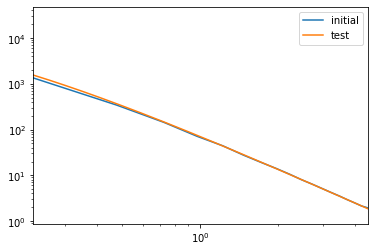

In [ ]:
#pkr_ic0 = condensed_1d_ps(A_s = 90, n_s = -2.55, m_s = -0.04, n_skewers = 4000, snr_min = 2, snr_max = 10, alpha = 2.8)

plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')
plt.loglog(klin, plin, label = 'test')
legend()

plt.xlim(min(pkr_ic0[0]), max(pkr_ic0[0]))
print(pkr_ic0[0])